# Training of Neural Network for Novozyme Prediction
This NB allows you to test a NN model and get training infos
The different parts are:
- Simple train: train a NN based on the parameters in the config file
- Compute learning curve: mse for a dataset of 100/1000/3000/all rows
- Compute feature importance: use saved models and scalers to compute the avg mse with each features being randomized one at a time
- Compute submission: use saved models and scalers to compute the avg mse for each row of the submission dataset

Note: for hyper parameters optimization see the wandb_training.py script, in which we use wandb to sweep through a list of posssible hyper parameters

In [1]:
import torch
import numpy as np
import pandas as pd
import time

from training_utils.file_utils import open_json, write_json 
from training_utils.save_results import (save_submission, log_kfold_training, log_learning_curve, 
                                        move_models_and_scalers, load_models_and_scalers)
from training_utils.models import HybridNN
from training_utils.model_utils import *
from training_utils.training import k_fold_training


In [2]:
KEEP_MODELS = True

SIMPLE_TRAIN = True
COMPUTE_LEARNING_CURVE = False
COMPUTE_FEATURE_IMPORTANCE = False
COMPUTE_SUBMISSION = True

USE_PDB_CHAIN_VOXEL_FOR_SUBMISSION = True # must be true from 0.08 to 0.42 for cnn only !

TRAINING_DIR = "outputs/hybrid_3"

config = open_json("hybrid_nn_config.json")
features_dict = open_json(
    f"{config['dataset_dir']}/{config['features_name']}.json")
features, features_infos = compute_feature_list(config, features_dict)
device = get_device(config)
log_name = config["model_type"]

# if there is only one target replace "dTm_loss_coef" with either 1 (dTm in targets) or 0 (ddG in targets)
if config["targets"] == ["ddG"]:
    config["dTm_loss_coef"] = 0
elif config["targets"] == ["dTm"]:
    config["dTm_loss_coef"] = 1


print(len(features))
print(len(features_infos["direct_features"]))
print(config["batch_size"])

cuda
289
289
1024


## Simple train


loaded 6196 data
no valid ksplit path given, doing ksplit without groups


100%|██████████| 10/10 [41:39<00:00, 250.00s/it]


logged training in ./outputs/hybrid_3


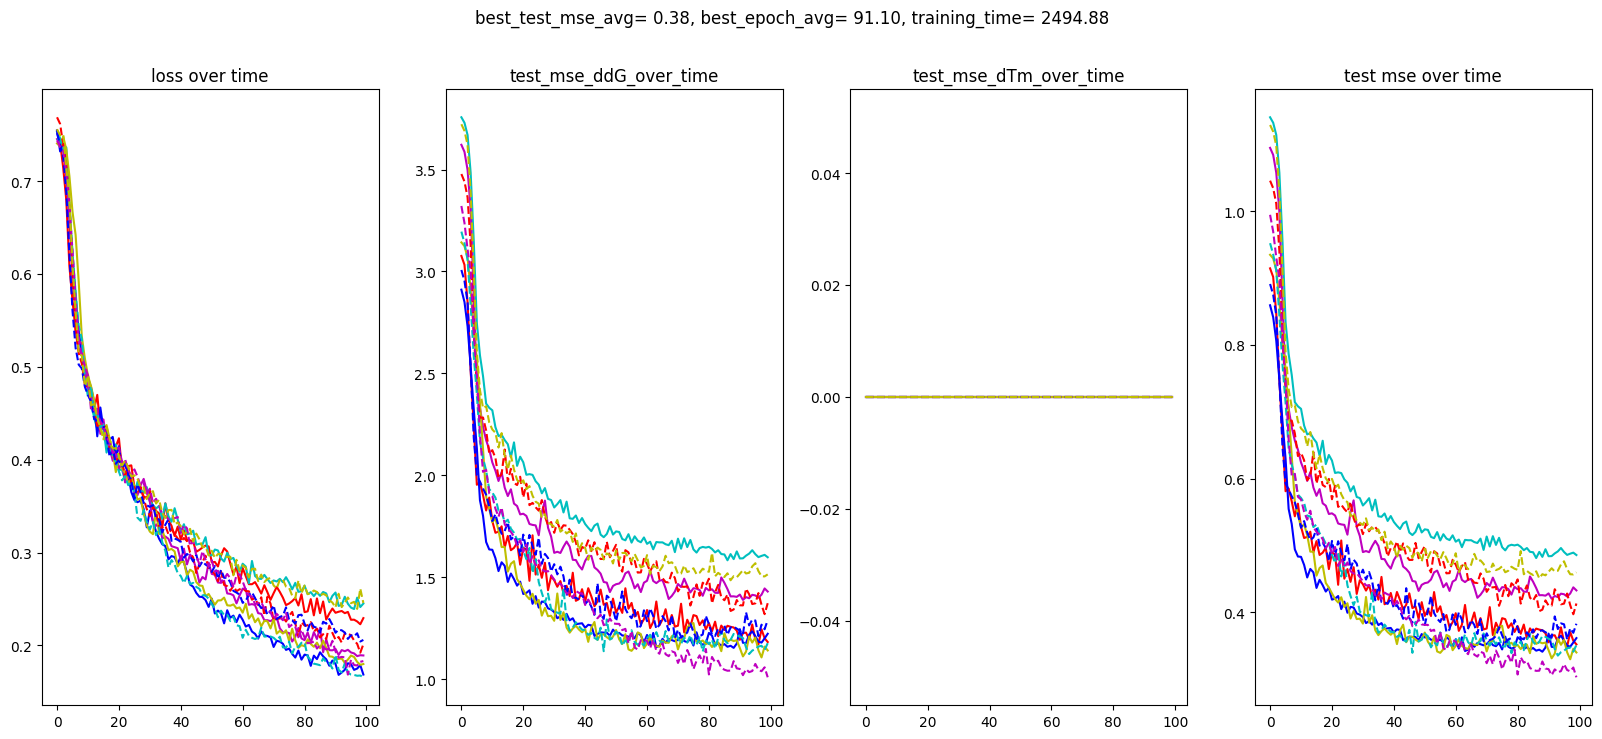

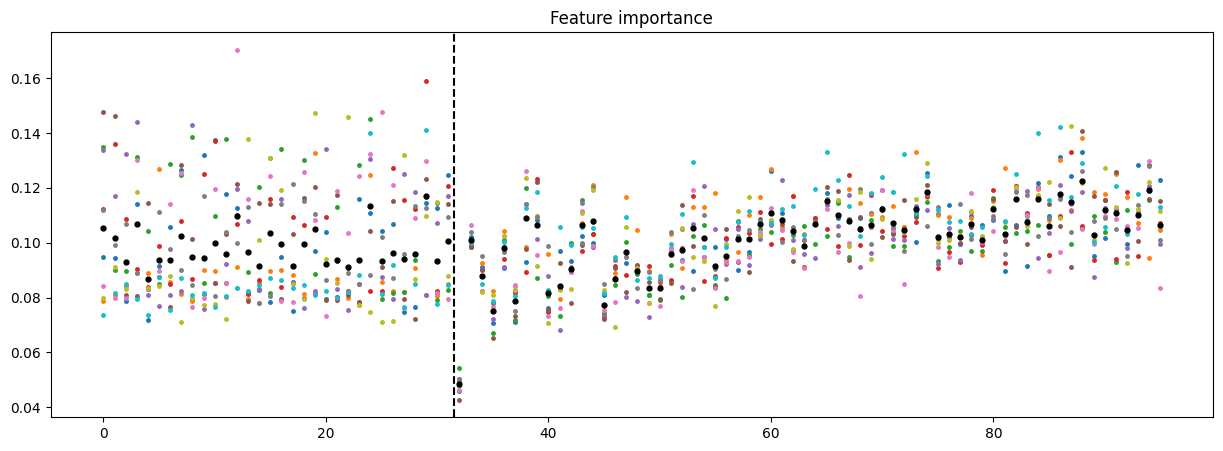

In [3]:
if SIMPLE_TRAIN:
    df = load_dataset(config, features, rm_nan=True)

    all_training_results = {"simple_train": [],
                            "total_training_time": 0}

    # add protein_index to the dataset and get ksplit:
    df = split_dataset(df, config)
    # training
    training_results = k_fold_training(
        df, config, features, features_infos, device, keep_models=KEEP_MODELS)

    # add training results to all the other ones
    all_training_results["simple_train"] = training_results
    
    # save results to output
    model = HybridNN(config)
    model_structure = str(model).replace(
        '(', '').replace(')', '').split('\n')
    dir_path = log_kfold_training(
        log_name, all_training_results, config, features, model_structure)

    if KEEP_MODELS:
        move_models_and_scalers(dir_path)

    print(f"logged training in {dir_path}")


## Learning Curve


In [4]:
if COMPUTE_LEARNING_CURVE:
    df = load_dataset(config, features)

    # plot the learning curve of the model
    # ie. the avg mse when df has 10, 100, 1000 elements
    # len(df) = 5k
    num_rows = [100, 1000, 3000, len(df)]
    all_training_results = {"training_by_num_rows": [],
                            "learning_curve": {"num_rows": num_rows,
                                               "train_mse": [],
                                               "test_mse": []
                                               },
                            "total_training_time": 0
                            }

    t0 = time.time()
    for n in num_rows:
        print(f"training on {n} rows from the dataset")
        df_n_rows = df.sample(n)
        # add protein_index to the dataset and get ksplit:
        df_n_rows, ksplit = split_dataset(df_n_rows, config)
        training_results = k_fold_training(
            df_n_rows, ksplit, config, features, features_infos, device)

        # add training results to all the other ones
        all_training_results["training_by_num_rows"].append(training_results)
        # compute avg_mse and time
        train_mse = sum(x["train_mse"]
                        for x in training_results)/config["kfold"]
        test_mse = sum(x["test_mse"]
                       for x in training_results)/config["kfold"]
        training_time = sum(x["time"] for x in training_results)

        # update result variables
        all_training_results["total_training_time"] += training_time
        all_training_results["learning_curve"]["train_mse"].append(train_mse)
        all_training_results["learning_curve"]["test_mse"].append(test_mse)

    total_time = time.time()-t0
    print(f"total_training_time= {all_training_results['total_training_time']:.2f}, {total_time= :.2f}, \
        training_time: {(all_training_results['total_training_time']/total_time)*100:.2f}% of total time")


In [5]:
if COMPUTE_LEARNING_CURVE:
    # save results to output
    model = HybridNN(config)
    model_structure = str(model).replace('(', '').replace(')', '').split('\n')
    dir_path = log_learning_curve(
        log_name, all_training_results, config, features, model_structure)
    print(f"logged training in {dir_path}")


## Feature Importance
cf model_visualization NB

# Predicting on submission


In [6]:
if COMPUTE_SUBMISSION:
    dir_path = TRAINING_DIR
    submission_df = pd.read_csv(
        f"{config['dataset_dir']}/submission_6_12.csv")

    if USE_PDB_CHAIN_VOXEL_FOR_SUBMISSION:
        submission_df["direct_voxel_features"] = submission_df["kaggle_voxel_path"].apply(
            np.load)
    else:
        # load voxel directly in df
        submission_df["direct_voxel_features"] = submission_df["direct_voxel_path"].apply(
            np.load)
    ddG_results = []
    dTm_results = []
    y_test_ddG = None
    y_test_dTm = None

    model_list, all_scalers, all_pca_directs = load_models_and_scalers(dir_path)

    for k in range(len(model_list)):
        model = model_list[k]  # model result from the training
        model.to(device)
        dataset_train_scaler = all_scalers["X"][k]  # scaler from training
        ddG_scaler = all_scalers["ddG"][k]
        dTm_scaler = all_scalers["dTm"][k]
        pca_direct = all_pca_directs[k]

        X_voxel_features, X_features, _, _ = prepare_eval_data(submission_df, config,
                                                            features, features_infos,
                                                            dataset_train_scaler,
                                                            pca_direct, submission=True)

        # Evaluate this model:
        model.eval()
        with torch.set_grad_enabled(False):
            X_voxel_features = X_voxel_features.to(device)
            X_features = X_features.to(device)
            y_test_ddG, y_test_dTm = model(X_voxel_features, X_features)
            if y_test_ddG is not None:
                y_test_ddG = y_test_ddG.cpu().detach().numpy()
                # we scale back the result to get to actual dTm and ddG values
                y_test_ddG = ddG_scaler.inverse_transform(y_test_ddG)
                # we append to the list of results
                ddG_results.append(y_test_ddG)
            if y_test_dTm is not None:
                y_test_dTm = y_test_dTm.cpu().detach().numpy()
                # we scale back the result to get to actual dTm and ddG values
                y_test_dTm = dTm_scaler.inverse_transform(y_test_dTm)
                # we append to the list of results
                dTm_results.append(y_test_dTm)

    submission = pd.DataFrame(columns=["seq_id", "tm"])
    submission["seq_id"] = submission_df["seq_id"]
    if y_test_dTm is not None:
        print("using dTm outputs of the model")
        submission["tm"] = np.mean(np.array(dTm_results), axis=0)
    else:
        print("using ddG outputs of the model")
        submission["tm"] = np.mean(np.array(ddG_results), axis=0)
    print(submission.head())
    save_path = save_submission(submission, TRAINING_DIR)
    print(f"{save_path=}")


using ddG outputs of the model
   seq_id        tm
0   31390 -0.611965
1   31391 -0.683735
2   31392 -0.880113
3   31393 -1.035653
4   31394 -1.047966
save_path='./submissions/hybrid_2022-12-19_22-15-25/hybrid_2022-12-19_22-15-25.csv'
